# Model Development and Apparent Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 5669 Columns: 113
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): patient_ID, site, dept, LZD_route
dbl  (20): patient_age, patient_weight, charlson, baseline_CLCR, baseline_WB...
lgl  (85): patient_sex, dept_ICU, dept_ER, dept_other, invasive_ETI, invasiv...
date  (4): baseline_date, LZD_start, LZD_end, test_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column t

                         P(B != 0 | Y)       model 1   model 2       model 3
Intercept                  1.000000000    1.00000000    1.0000    1.00000000
patient_age                0.754491015    1.00000000    1.0000    0.00000000
patient_sexTRUE            0.005036519    0.00000000    0.0000    0.00000000
LZD_dose_per_weight        0.004954494    0.00000000    0.0000    0.00000000
baseline_CLCR              0.292859796    0.00000000    0.0000    1.00000000
dept_ERTRUE                0.004521867    0.00000000    0.0000    0.00000000
dept_ICUTRUE               0.016463157    0.00000000    0.0000    0.00000000
baseline_HGB               0.129647625    0.00000000    0.0000    0.00000000
baseline_WBC               0.006231078    0.00000000    0.0000    0.00000000
baseline_PLT               1.000000000    1.00000000    1.0000    1.00000000
LZD_duration               0.999935031    1.00000000    1.0000    1.00000000
invasive_ETITRUE           0.156507712    0.00000000    0.0000    0.00000000

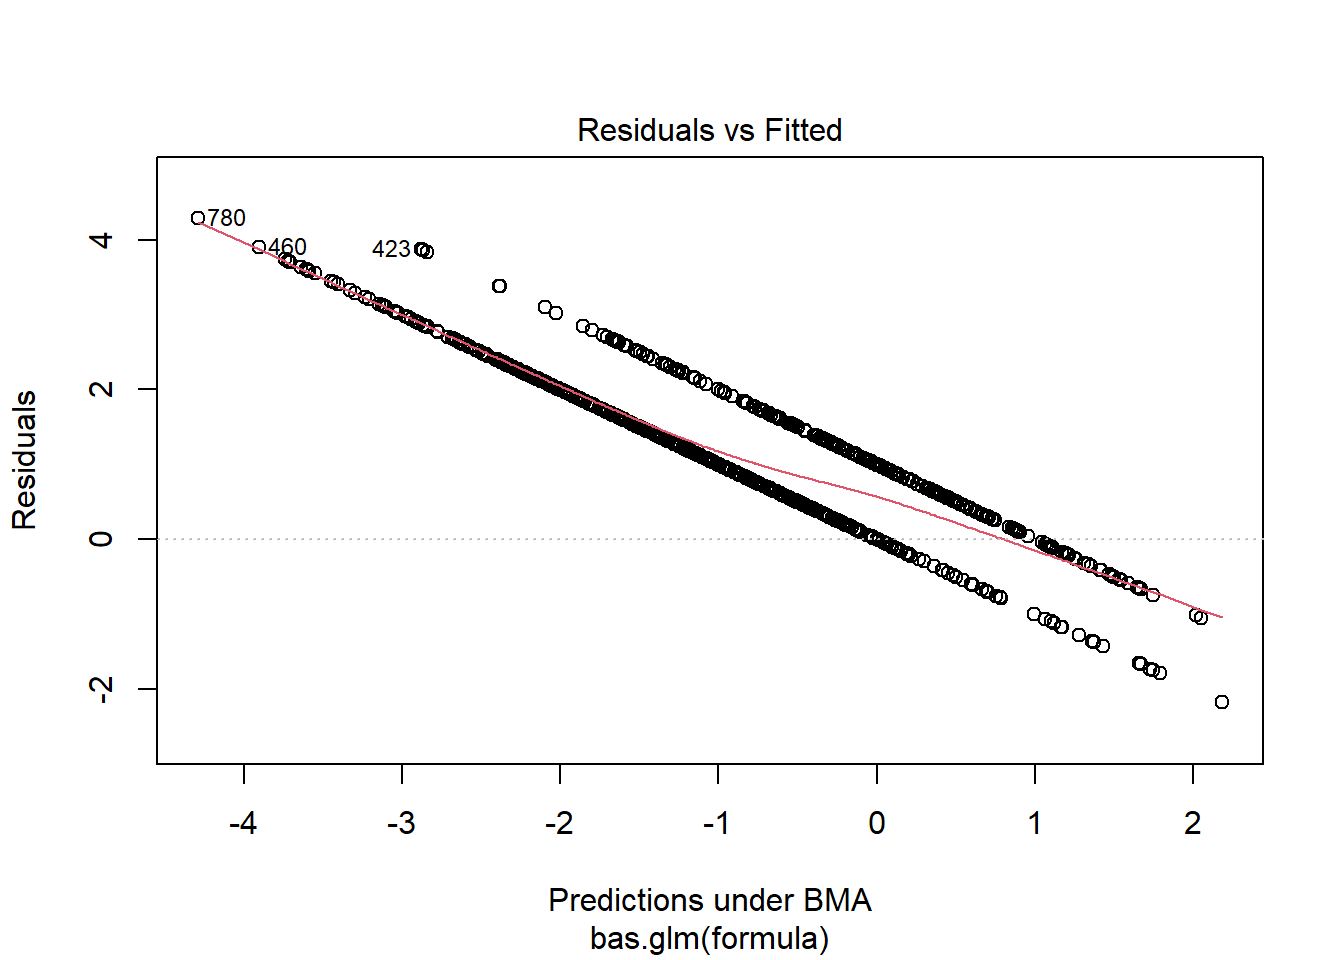

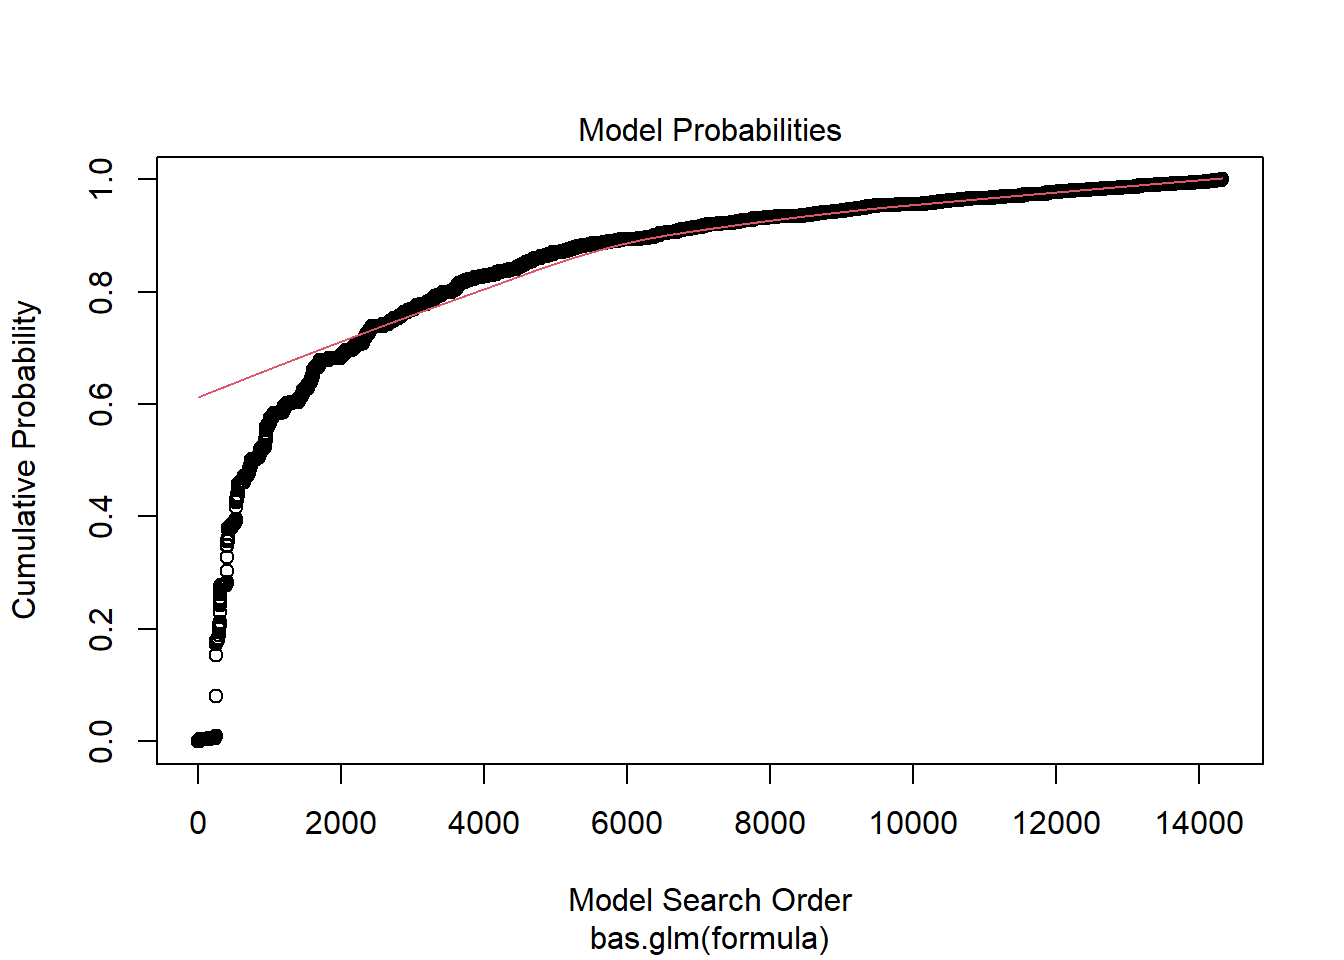

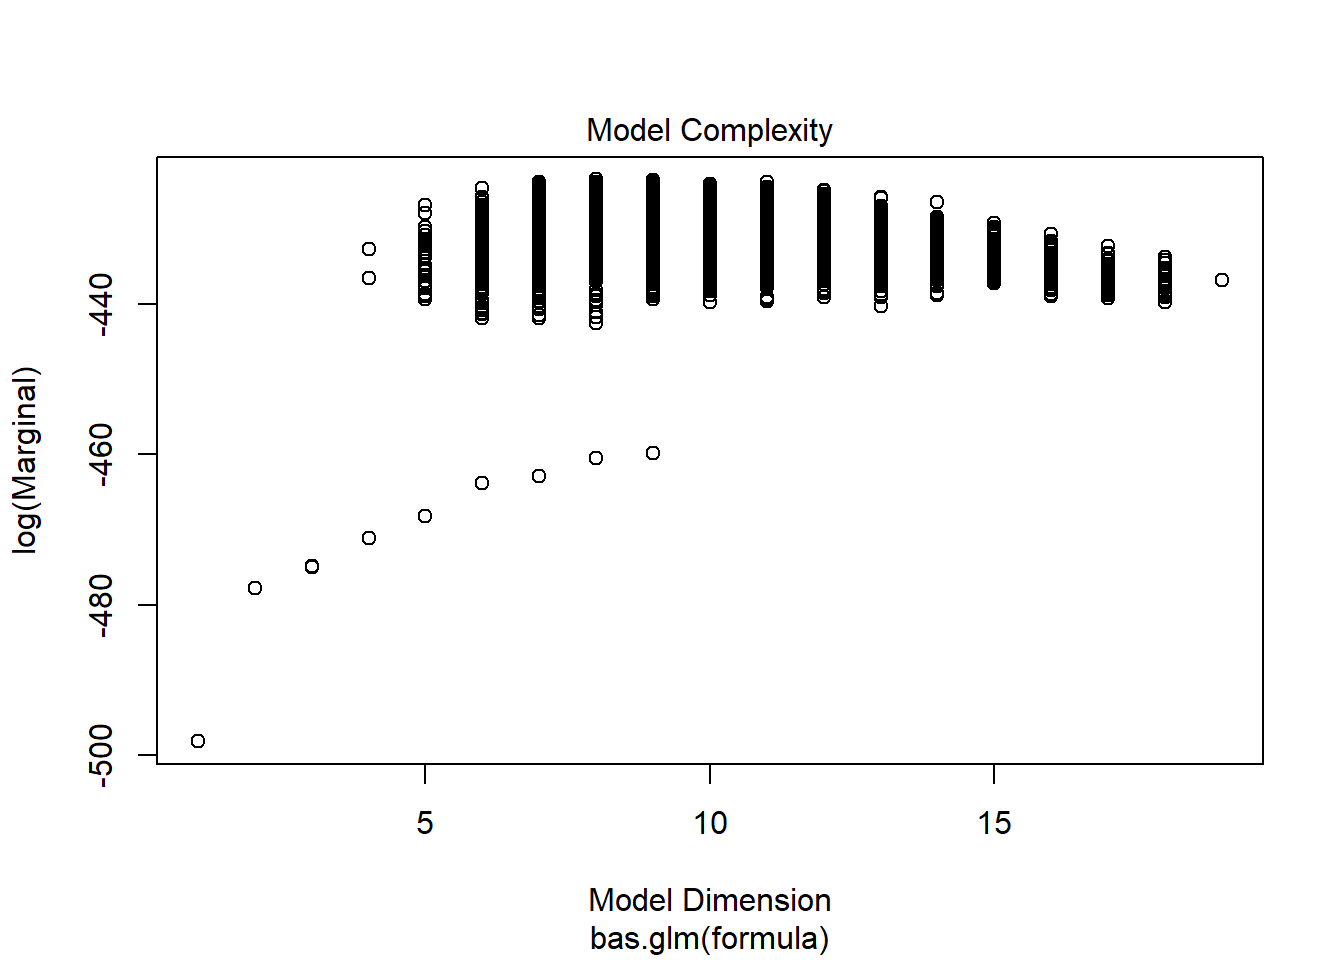

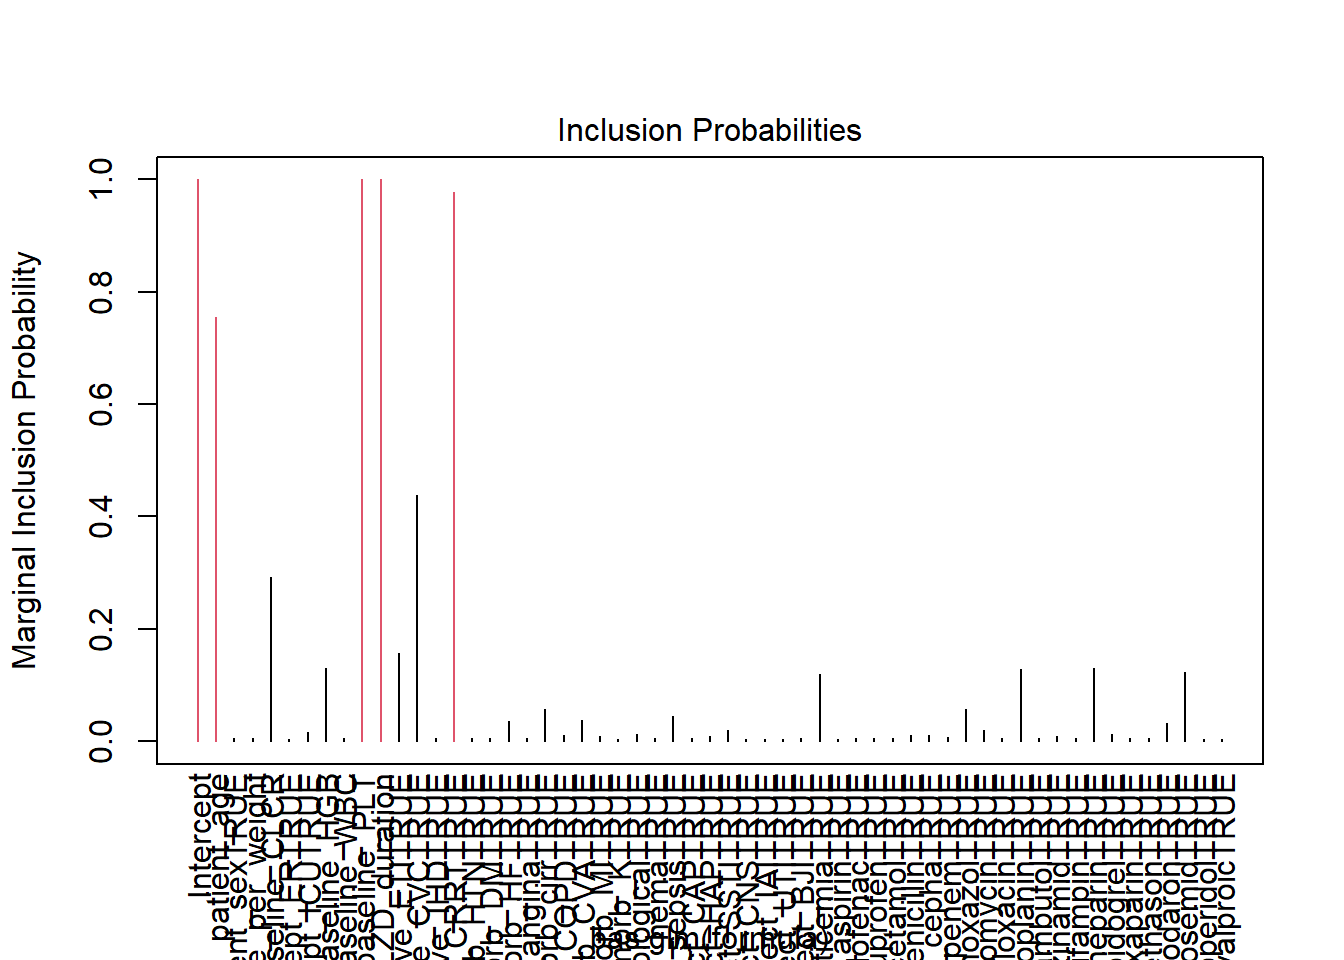

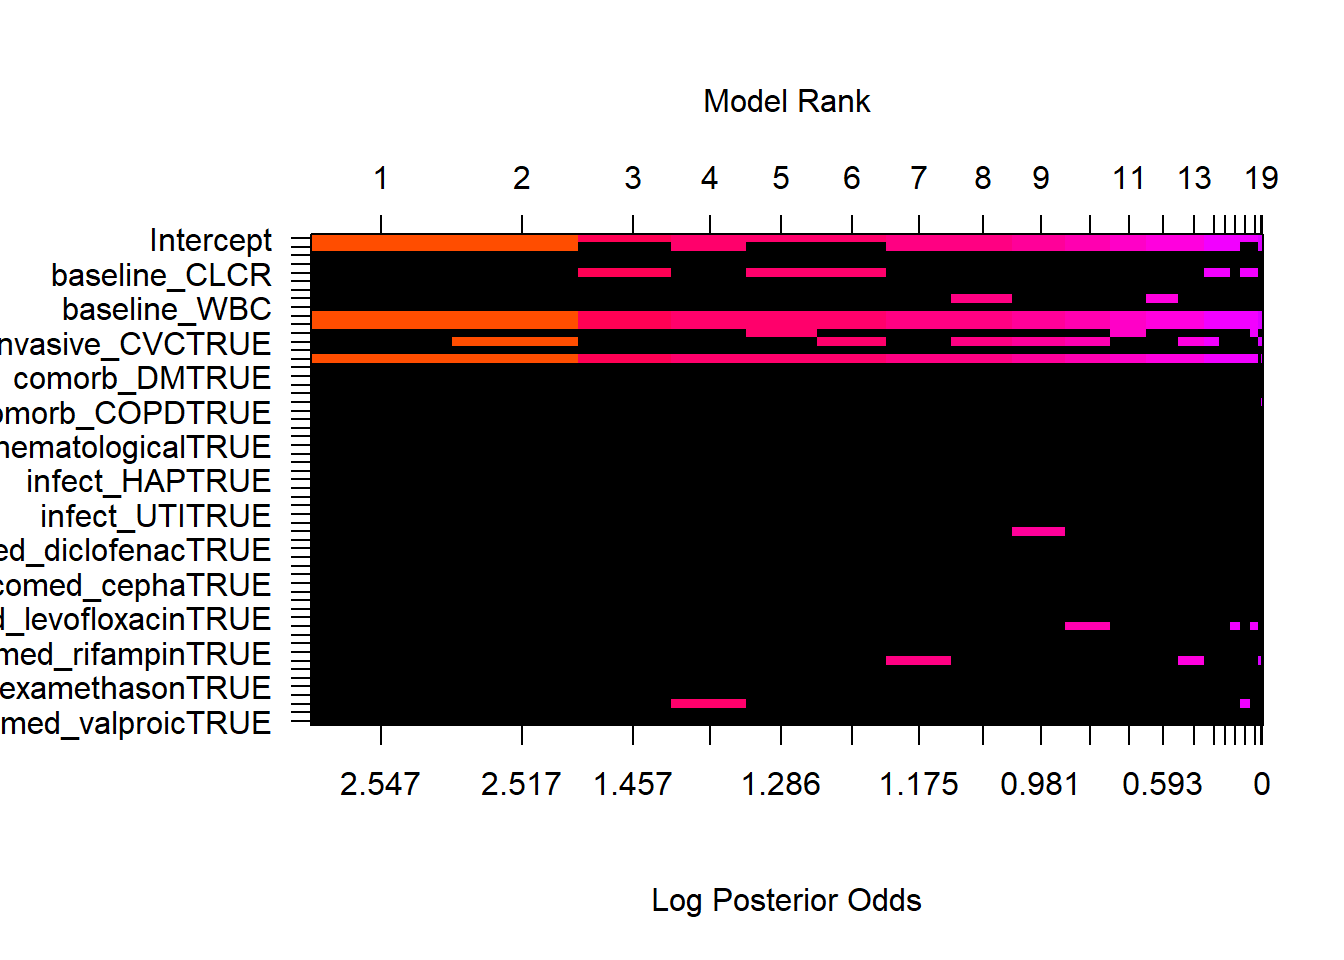

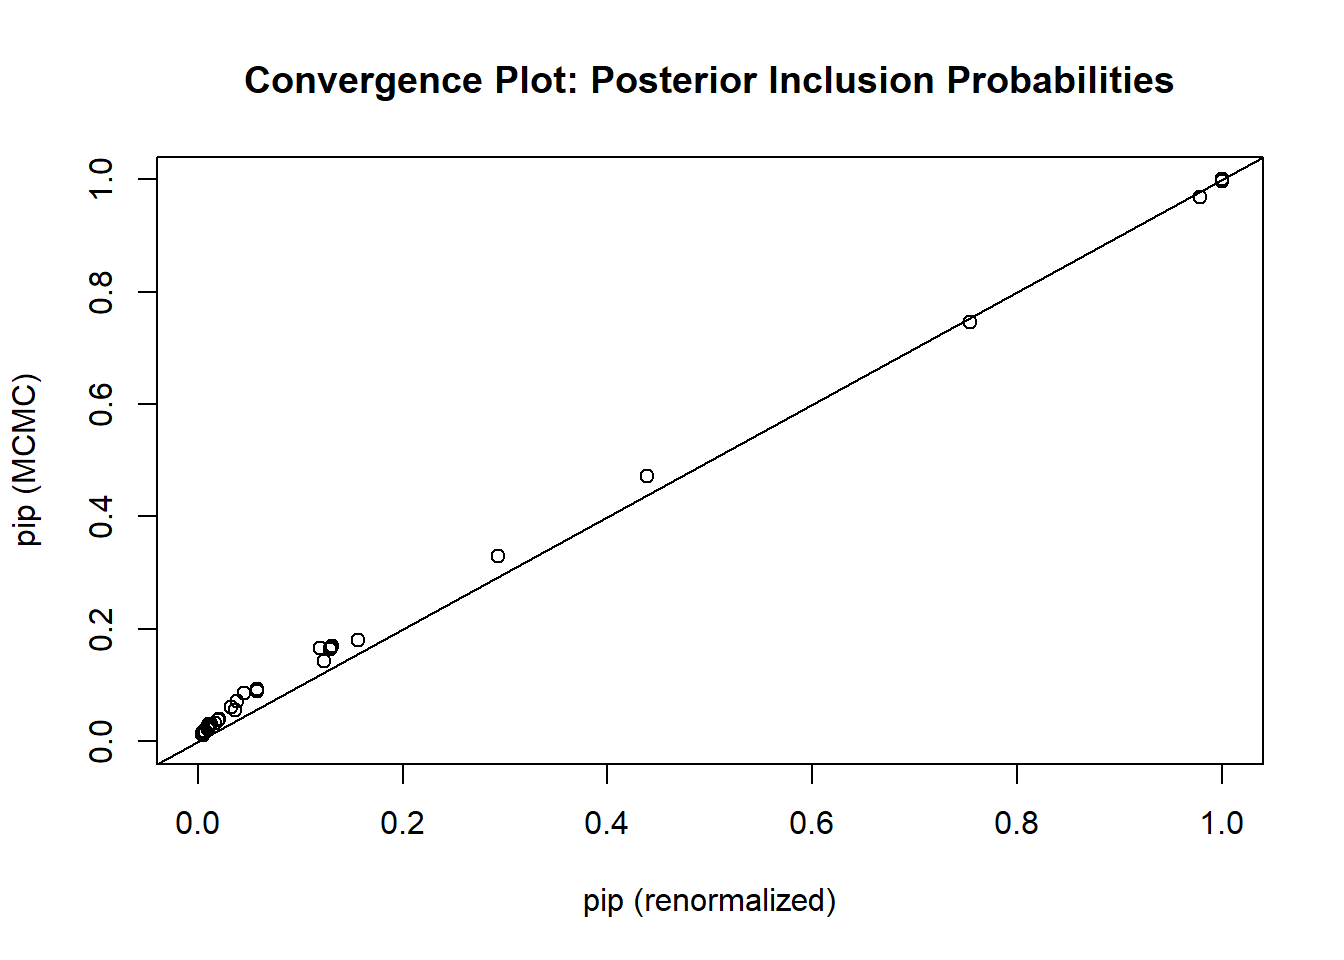

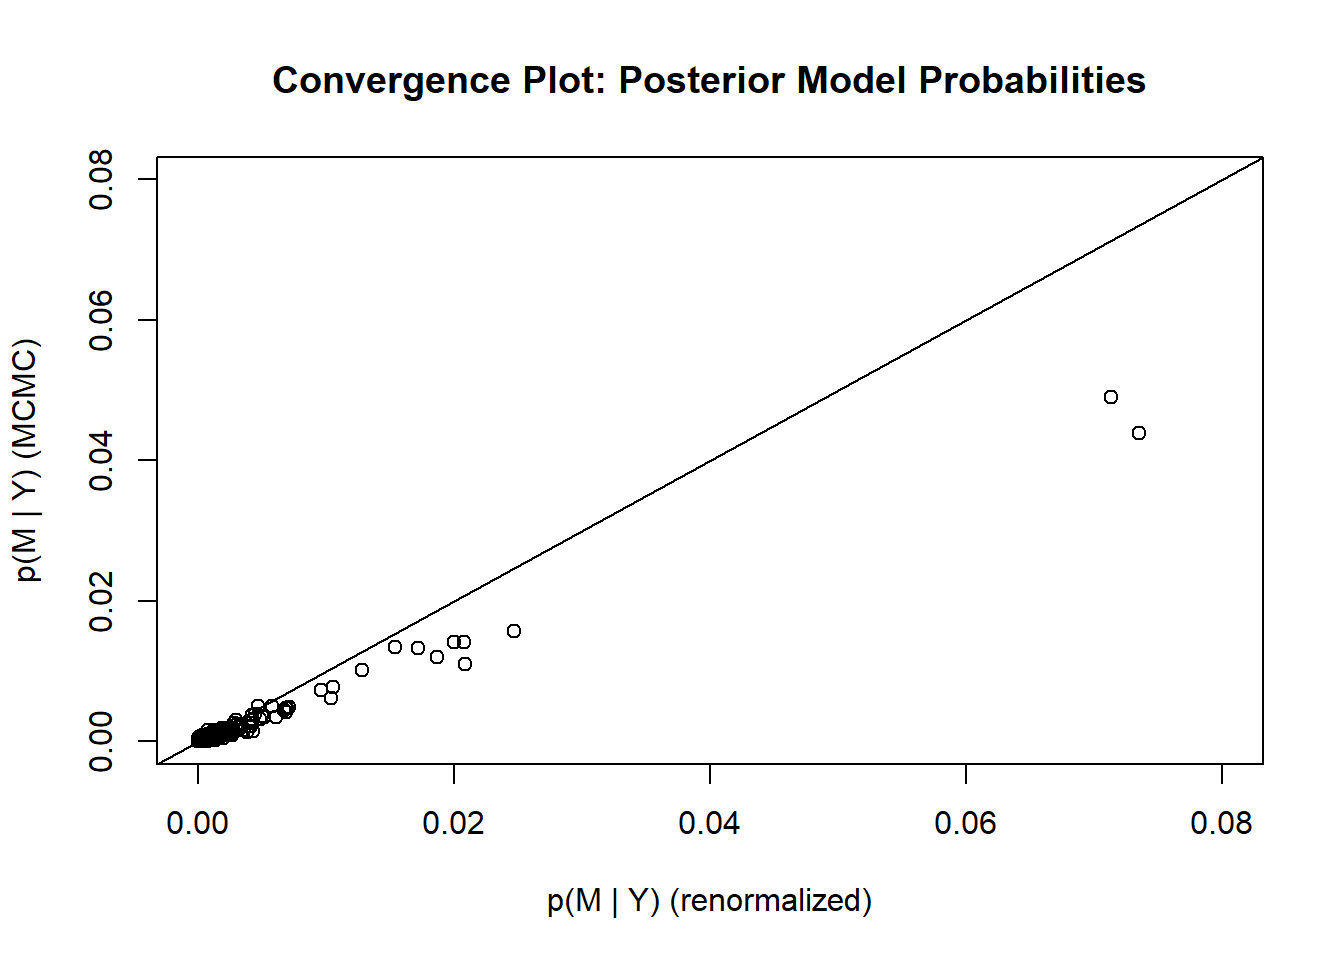

In [ ]:
multi_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .
  )

summary(multi_model)


In [ ]:
library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.3.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.3.0
✔ recipes      1.0.9     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

In [ ]:
library(CalibrationCurves)


Loading required package: rms

Loading required package: Hmisc


Attaching package: 'Hmisc'

The following object is masked from 'package:parsnip':

    translate

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

In [ ]:
save(model_full, file = "data/model-performance/model-full.rda")
